In [1]:
from dataloader.dataloader import *
from PIL import Image

from model.model import ResNetAE
import os
import torch
import numpy as np
from skimage import io
import trimesh

from utils.utils import get_peeled_intersections, get_rgb_peels, get_depth_peels, mesh_init
from utils.sceneflow import get_scf_peels
from utils.loss_utils import *
from utils.backproject import *
from dataloader.dataloader import *
from torchvision import transforms

In [2]:
dataset_path = '/home2/richa.mishra/4DReconstruction/dataset/03384'
seq_ID = '03384'

dataloader = TemporalDataloader(dataset_path, seq_ID, K_frames=2, 
                               batch_size = 2, shuffle=True)

In [3]:
for idx, d in enumerate(dataloader):
    print("idx = "+str(idx))
    rgb, dep1, dep2 = d
    print(rgb.shape)
    print(dep1.shape)
    B, K, C, H, W = rgb.shape
    B, K, n_peels, H, W = dep1.shape
    
    dep1 = dep1.reshape(B*K, n_peels, H, W)
    dep2 = dep2.reshape(B*K, n_peels, H, W)
    rgb = rgb.reshape(B*K, C, H, W)
    print(rgb.shape)
    print(dep1.shape)

idx = 0
torch.Size([1, 2, 18, 512, 512])
torch.Size([1, 2, 4, 512, 512])
torch.Size([2, 18, 512, 512])
torch.Size([2, 4, 512, 512])


In [4]:
pc_curr = batch_pointclouds(dep1[:,0,:,:])
for pcl in pc_curr:
    print(pcl.points_packed().shape)

torch.Size([15928, 3])
torch.Size([15903, 3])


In [5]:
pc_next_pred = batch_pointclouds_pred(rgb[:,6:9,:,:], dep1[:,0,:,:])
for pcl in pc_next_pred:
    print(pcl.points_packed().shape)

torch.Size([15928, 3])
torch.Size([15903, 3])


In [4]:
scf_zero = torch.zeros_like(rgb[:,6:,:,:])
print(scf_zero.shape)

torch.Size([2, 12, 512, 512])


In [5]:
pc_bp = backproject(scf_zero, dep1)

In [6]:
pc_bp[0,0,256,256], dep1[0,0,256,256], dep2[0,0,256,256]

(tensor(2.4157), tensor(2.4216), tensor(2.4248))

In [6]:
torch.where(pc_bp[0,0,:, :]>0)

(tensor([205, 205, 205,  ..., 511, 511, 511]),
 tensor([327, 328, 335,  ..., 336, 337, 338]))

In [9]:
len(torch.where(dep2[0,0,:, :]>0)[0]), len(torch.where(pc_bp[0,0,:,:]>0)[0])

(15903, 16764)

In [9]:
torch.max(dep2[0,:,:, :])

tensor(2.6781)

In [10]:
torch.max(pc_bp[0,:,:, :])

tensor(2.6925)

In [11]:
torch.max(rgb[:,6:9,:,:])

tensor(0.0568)

In [24]:
diff = torch.abs(pc_bp - dep1)
torch.mean(diff)

tensor(0.0065)

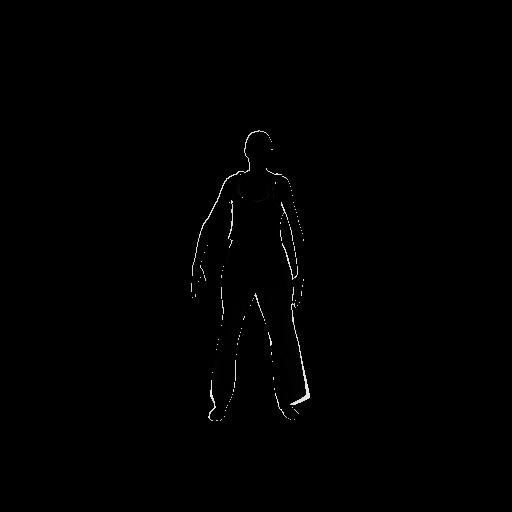

In [8]:
im = torch.ones_like(dep2)

diff = torch.abs(dep2 - pc_bp)
diff_img = Image.fromarray(np.uint8(diff[0,0,:,:]*90)).convert('RGB')
diff_img

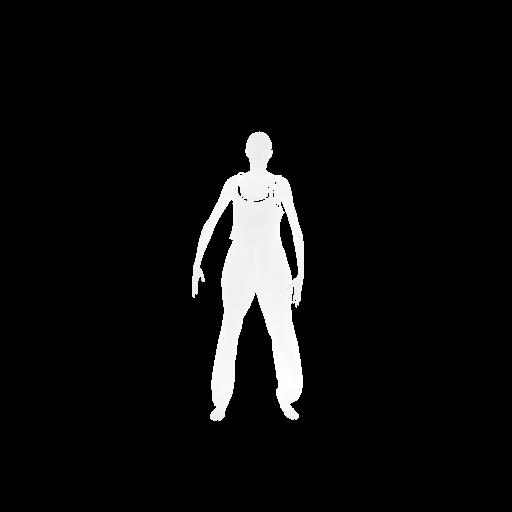

In [21]:
diff_img = Image.fromarray(np.uint8(dep2[0,0,:,:]*100)).convert('RGB')
diff_img

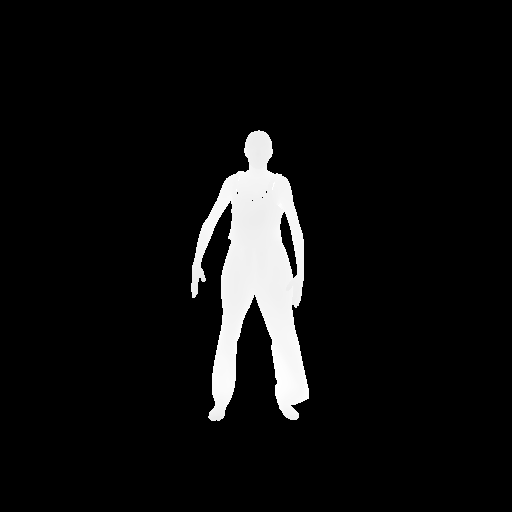

In [7]:
diff_img = Image.fromarray(np.uint8(pc_bp[0,0,:,:]*100)).convert('RGB')
diff_img